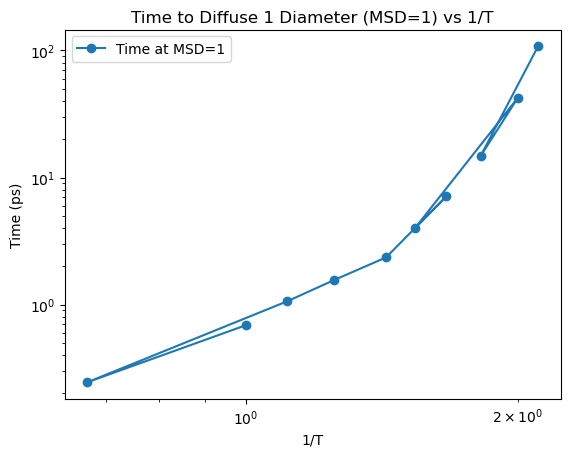

In [6]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
from MDAnalysis.analysis.msd import EinsteinMSD  # 导入 EinsteinMSD

# 创建 Figures 文件夹
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# 获取 .lammpstrj 和 .dcd 文件路径
lammpstrj_files = sorted(glob.glob("../equil/*.lammpstrj"))  # 替换为实际的 .lammpstrj 文件路径
dcd_files = sorted(glob.glob("../prod/*.unwrap.dcd"))  # 替换为实际的 .dcd 文件路径

# 定义 MSD 计算函数
def calculate_msd(universe, particle_type):
    msd_anal = EinsteinMSD(universe, select=f"type {particle_type}", msd_type="xyz", fft=True)
    msd_anal.run()
    times = msd_anal.times  # 获取时间数据
    msd_values = msd_anal.results.timeseries  # 获取 MSD 数据
    return times, msd_values

# 存储每个温度下的 MSD = 1 的时间和相应的 1/T
times_for_msd_1 = []
inv_temps = []

# 循环加载拓扑和轨迹文件，计算 MSD
for lammpstrj_file, dcd_file in zip(lammpstrj_files, dcd_files):
    # 使用正则表达式从文件名中提取温度，兼容整数和小数
    match = re.search(r'T(\d+\.?\d*)', lammpstrj_file)
    if match:
        temp = float(match.group(1))  # 提取到的温度值转换为浮点数
    else:
        print(f"无法从文件名 {lammpstrj_file} 提取温度信息")
        continue
    
    universe = mda.Universe(lammpstrj_file, dcd_file, topology_format="LAMMPSDUMP")
    
    # 计算类型 1 粒子的 MSD
    times, msd1 = calculate_msd(universe, particle_type=1)
    
    # 找到 MSD 最接近 1 的时间
    idx = np.argmin(np.abs(msd1 - 1))  # 找到最接近 MSD=1 的索引
    time_at_msd_1 = times[idx]
    
    # 存储数据
    times_for_msd_1.append(time_at_msd_1)
    inv_temps.append(1 / temp)

# 绘制 MSD=1 的时间 vs 1/T 的 log-log 图
plt.figure()
plt.loglog(inv_temps, times_for_msd_1, 'o-', label="Time at MSD=1")
plt.xlabel('1/T')
plt.ylabel('Time (ps)')
plt.title('Time to Diffuse 1 Diameter (MSD=1) vs 1/T')
plt.legend()
plt.savefig(f"{output_dir}/Time_vs_InvTemp_LogLog.png")
plt.show()
